# Bayesian Generalized Linear Models with Pyro



In [ ]:
!pip install pyro-ppl

     |████████████████████████████████| 614kB 2.6MB/s 


One of the most common "first lines of attack" when faced with a predictive or analytical data project is the family of Generalized Linear Models (GLMs), and most commonly the linear or logistic regressions.

GLMs seek to model a response variable, $y$, as a function of a linear combination of features, $X$. The reason for the linear combination is largely for the purpose of explainability; We want to not only be able to predict y well, but also be able to explain what is the effect of each feature on our response.

Thus, we usually specify a GLM as our response being a combination of features and coefficients as follows:

$$y = f(\beta_0 + \beta_1 x_1 + \beta_2 x_2 ... + \beta_n x_n)$$

where $f$ is a function of our linear combination, and the coefficients are denoted with the Greek letter $\beta$


While libraries such as `sklearn` offer a rich variety of regression models, they have one major drawback in that they create point estimates of $\beta$ without taking uncertainty into account. That is, while we can find out what are the most likely values for the coefficient, we don't estimate how likely are other values for the coefficients. Other packages such as `statsmodels` offer some measure of uncertainty, but do so under a series of implicit assumptions the analyst may not get to verify (or know about).


In this article we'll discuss how to leverage PyTorch and Pyro to produce GLM models which create uncertainty estimates both for the parameters, as well as for predictions, and do so with a set of very explicit assumptions.

## Employing Scikit-learn's Linear Regression

We'll start by exploring a simple linear regression from `sklearn`, and see how it behaves on one of the built in datasets, the California Housing dataset.

We'll start by importing all our required libraries:

In [ ]:
import time         # We will time our execution often

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Now let's import the housing dataset, and explore its features

In [ ]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()

X = california.data
y = california.target * 100000

print(f'Data shape is {X.shape}')
print(f'Target shape is {y.shape}')

Data shape is (20640, 8)
Target shape is (20640,)


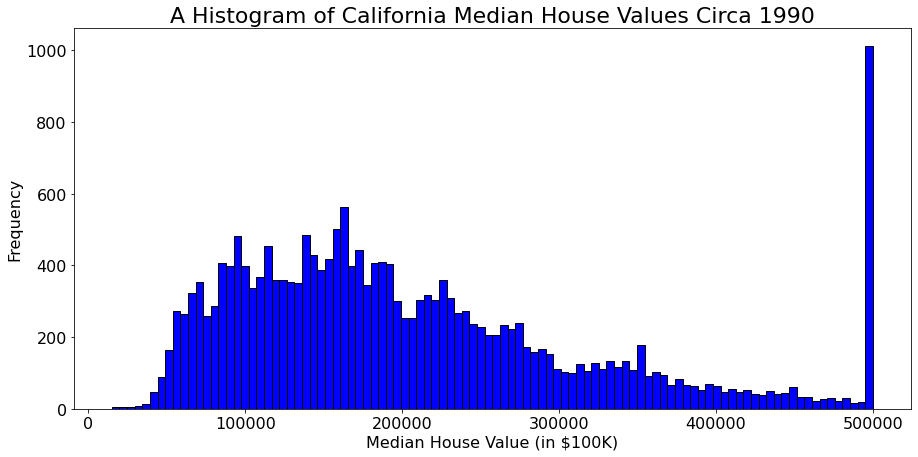

In [ ]:
plt.figure(figsize=(15,7))
plt.hist(y, bins=100, color="blue", edgecolor="black")
plt.xlabel("Median House Value (in $100K)", size=16)
plt.ylabel("Frequency", size=16)
plt.title("A Histogram of California Median House Values Circa 1990", size=22)
plt.xticks(size=16)
plt.yticks(size=16)
plt.show()

The base linear regression model in many libraries assumes the response is normally distributed around the predicted means. However, generally house prices won't be normally distributed. In this dataset as well, the distribution of prices is not normal, it is closer to a [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) (In reality, we won't always get that directly from the data, but might have to look at residuals, but this simple alternative works in our case). So it would be nice if we were able to build our model so it takes that into account.


First, let's explore how well an `sklearn` linear regression performs on this data. We can split the data into train and test sets to get an estimate of how our algorithms will work:

In [ ]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16512, 8) (16512,)
(4128, 8) (4128,)


Let's fit our linear regression:

In [ ]:
# start timing
start_time = time.time()

# fit linear regression
my_linear_regression = LinearRegression().fit(X_train,y_train)
y_pred = my_linear_regression.predict(X_test)

end_time = time.time()

# print point estimates of the coefficients
print(f"beta_intercept: {round(my_linear_regression.intercept_, 2)}")
for i, col in enumerate(california.feature_names):
    print(f"beta_{col}: {round(my_linear_regression.coef_[i], 2)}")

beta_intercept: -3699989.72
beta_MedInc: 44501.27
beta_HouseAge: 979.0
beta_AveRooms: -11817.06
beta_AveBedrms: 77540.07
beta_Population: -0.24
beta_AveOccup: -409.04
beta_Latitude: -41842.05
beta_Longitude: -43304.03


Let's define a function to plot our predictions and the true values for the held out test set:

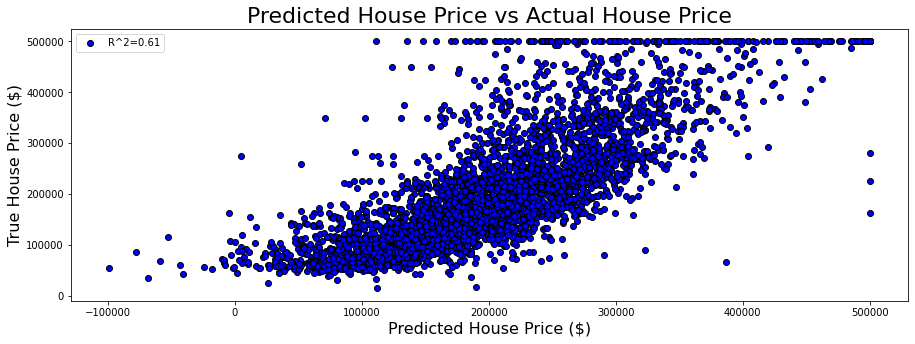

In [ ]:
def plot_all_observations(y_true, y_pred, y_max):

    y_pred_censored = np.where(y_pred > y_max, y_max, y_pred)

    plt.figure(figsize=(15, 5))
    plt.scatter(y_pred_censored, y_test,
                c="blue", edgecolor="black",
                label=f'R^2={round(r2_score(y_test, y_pred_censored),2)}')

    plt.title("Predicted House Price vs Actual House Price", size=22)
    plt.xlabel("Predicted House Price ($)", size=16)
    plt.ylabel("True House Price ($)", size=16)
    plt.ticklabel_format(style='plain')
    plt.legend()

    plt.show()



# Now let's call our function
y_censor_label = y_train.max()
plot_all_observations(y_test, y_pred, y_censor_label)

There are some observations in our data which are censored. That is, their label seems to be houses which cost $500,000+. We can define another function which plots only points which are not censored:

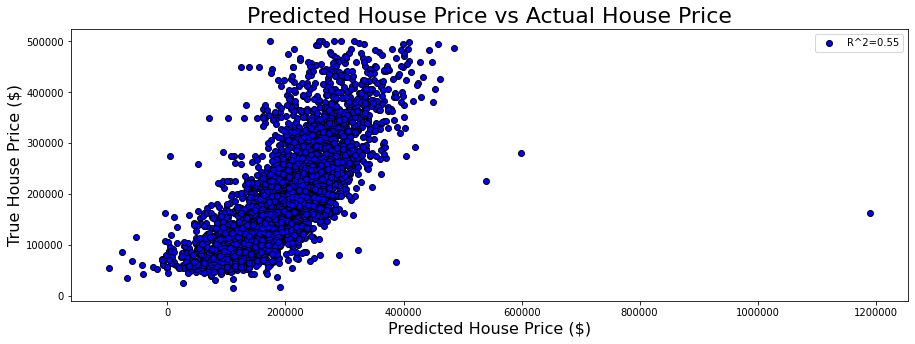

In [ ]:
def plot_uncensored_observations(y_true, y_pred, y_censor_label):

    y_test_uncensored = y_test[y_test<y_censor_label]
    y_pred_uncensored = y_pred[y_test<y_censor_label]

    plt.figure(figsize=(15, 5))
    plt.scatter(y_pred_uncensored, y_test_uncensored,
                c="blue", edgecolor="black",
                label=f'R^2={round(r2_score(y_test_uncensored, y_pred_uncensored),2)}')

    plt.title("Predicted House Price vs Actual House Price", size=22)
    plt.xlabel("Predicted House Price ($)", size=16)
    plt.ylabel("True House Price ($)", size=16)
    plt.ticklabel_format(style='plain')
    plt.legend()

    plt.show()



# Now let's call our function
plot_uncensored_observations(y_test, y_pred, y_censor_label)

While this approach can produce satisfactory results, it suffers from a few main drawbacks:
* First, the linear model generally ignore the fact that the prices come from a Gamma distribution. Its calculations of the expected value for every point are predicated on the mean coming from a Normal distribution.
* Second, for each coefficient, we only get a point estimate of its most likely value. However, we might be interested in a range which accounts for uncertainty. For example, we might want to know what is the range of price increases we can expect for each additional bedroom.


To address these problems, we can employ [Pyro](https://pyro.ai/) and [PyTorch](https://pytorch.org/) to construct our own linear model which will address all the pain points just mentioned.

------

## Reconstructing the Linear Model with Pyro

First, let’s try and replicate the findings of the simple linear regression with Pyro. This will give us an intuition for how the different Pyro primitives work:

In [ ]:
# import all required Pyro/Pytorch libraries
import torch
torch.set_default_tensor_type(torch.FloatTensor) # set the default to float32

import pyro
import pyro.distributions as dist

# We will use Markov Chain Monte Carlo (MCMC) methods here, specifically the No U-Turn Sampler (NUTS)
from pyro.infer import MCMC, NUTS

First, we will define our model in Pyro. Pyro models are defined as functions (actually they are defined as callables, but the simplest callable is a function). The function will accept our features $X$, our target $y$, and also the feature names for easier naming of priors:

In [ ]:
def model_normal(X, y, column_names):

    # Define our intercept prior
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)


    # Also define coefficient priors
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        linear_combination = linear_combination + (X[:, i] * beta_coef)


    # Define a sigma prior for the random error
    sigma = pyro.sample("sigma", dist.HalfNormal(scale=10.0))

    # For a simple linear model, the expected mean is the linear combination of parameters
    mean = linear_combination


    with pyro.plate("data", y.shape[0]):

        # Assume our expected mean comes from a normal distribution with the mean which
        # depends on the linear combination, and a standard deviatin "sigma"
        outcome_dist = dist.Normal(mean, sigma)

        # Condition the expected mean on the observed target y
        observation = pyro.sample("obs", outcome_dist, obs=y)

In essence what we've done here is define our linear regression as the following linear combination of parameters


$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \mathcal{N}(0, \sigma^2)$$

However, unlike traditional linear regressions, we've defined each beta coefficient, as well as the error term, to be a distribution instead of a single values. That is, for each coefficient, we can ask what is the range of possible values this coefficient can assume given the data we observed. We gave a name to each of those distributions (e.g. `beta_intercept`) for easy reference later.


We had to define priors on each coefficient. A prior is like our “best guess” for that value. Our chosen priors were:


$$\beta_i \sim \mathcal{N}(0, 1^2)$$<br>
$$\sigma \sim \text{HalfNormal}(0.0, 10^2)$$<br>

These are not very informative priors, but they are commonly used for regression coefficients and error terms.
One important point to notice is that we have to be explicit about these choices when building our model. That is, we have to be clear about what are reasonable priors for the coefficient values, the error term, and the distribution of values around our predicted value.

Once the priors are defined, we can ask Pyro to update them into better and better guesses through the magic of MCMC samplers:

In [ ]:
SAMPLE_NUMBER = 3000


# Turn out numpy data into PyTorch
# tensors
X_train_torch = torch.tensor(X_train)
y_train_torch = torch.tensor(y_train)



# Clear the parameter storage
pyro.clear_param_store()

# Initialize our No U-Turn Sampler
my_kernel = NUTS(model_normal,
                 max_tree_depth=7) # a shallower tree helps the algorithm run faster

# Employ the sampler in an MCMC sampling
# algorithm, and sample 3100 samples.
# Then discard the first 100
my_mcmc1 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)


# Let's time our execution as well
start_time = time.time()

# Run the sampler
my_mcmc1.run(X_train_torch,
             y_train_torch,
             california.feature_names)

end_time = time.time()

print()
print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 3100/3100 [39:23,  1.31it/s, step size=2.49e-03, acc. prob=0.970]

Inference ran for 39.39 minutes


If you are interested in a breakdown of what has happened here, I recommend that you check out [my previous](https://towardsdatascience.com/probabilistic-programming-with-pyro-and-kitchen-scale-f8d6a5d9ae0f) post which explores the use of MCMC methods to optimize a single parameter.


We can explore the estimates found by our MCMC sampler for each of our coefficients using the `.summary()` method:

In [ ]:
my_mcmc1.summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_intercept     -1.82      0.05     -1.83     -1.90     -1.74      3.24      1.51
      beta_MedInc      0.57      0.06      0.55      0.49      0.67      2.80      2.38
    beta_HouseAge      0.33      0.73      0.33     -0.87      1.36      2.52      2.66
    beta_AveRooms     -0.66      0.05     -0.67     -0.72     -0.59      2.53      2.84
   beta_AveBedrms      0.40      0.02      0.40      0.36      0.44      4.49      1.07
  beta_Population     84.35      9.93     85.57     84.89     86.28     64.71      1.01
    beta_AveOccup      1.97      0.02      1.97      1.94      2.00     10.52      1.00
    beta_Latitude      1.07      0.48      1.06      0.40      1.87      2.57      2.49
   beta_Longitude    -13.35      8.38    -13.56    -24.75      0.78      2.51      2.65
            sigma  14968.01    277.87  14933.59  14899.89  14966.91     42.34      1.04

Number of divergences: 0


Those don't look quite right... The means seem very different from the point estimates found by the regression from `sklearn`.

Let's grab the individual samples from our sampler, and turn those into a dataframe (they are returned as a dictionary). We can grab the mean of each distribution as a coefficient point estimate, and then calculate a set of predictions for our data points. Then, we can compare them to our known values for house prices:

In [ ]:
beta_df = pd.DataFrame(my_mcmc1.get_samples())
beta_df.head()

,beta_intercept,beta_MedInc,beta_HouseAge,beta_AveRooms,beta_AveBedrms,beta_Population,beta_AveOccup,beta_Latitude,beta_Longitude,sigma
0,-1.782288,0.519877,-0.867081,-0.689961,0.399474,3.031769,1.988785,0.235826,0.775655,17275.772917
1,-1.782337,0.519880,-0.867108,-0.689944,0.399495,3.036217,1.988796,0.235806,0.775615,17277.326224
2,-1.782323,0.519846,-0.867128,-0.689954,0.399525,3.042149,1.988793,0.235819,0.775606,17275.428645
3,-1.782298,0.519882,-0.867205,-0.689899,0.399422,3.067178,1.988770,0.235789,0.775647,17278.027242
4,-1.782276,0.519871,-0.867213,-0.689958,0.399432,3.090615,1.988789,0.235772,0.775940,17282.335918


In [ ]:
def predict_linear_combination(beta_df, X):

    # Don't grab the last column, that is our estimate of the error standard deviation, "sigma"
    coefficients = beta_df.iloc[:, :-1].mean()

    # Find our linear combination again
    linear_combination = X.dot(coefficients[1:]) + coefficients.iloc[0]

    return linear_combination

In [ ]:
linear_combination = predict_linear_combination(beta_df, X_test)
# Our predictions are the linear combination
y_pred = linear_combination

Let's plot the results and calculate the $R^2$ value for our predictions:

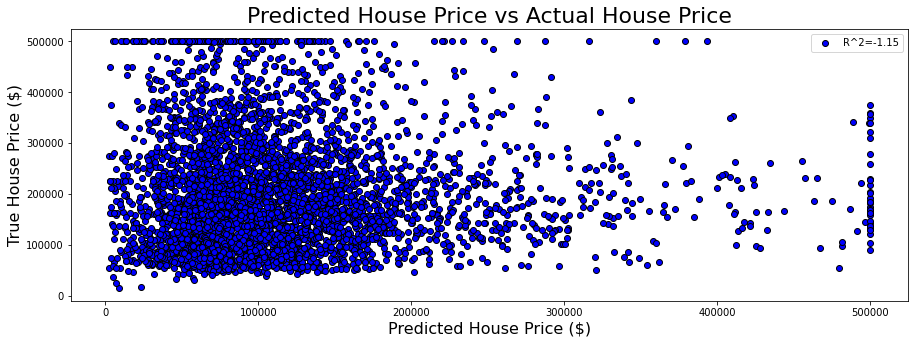

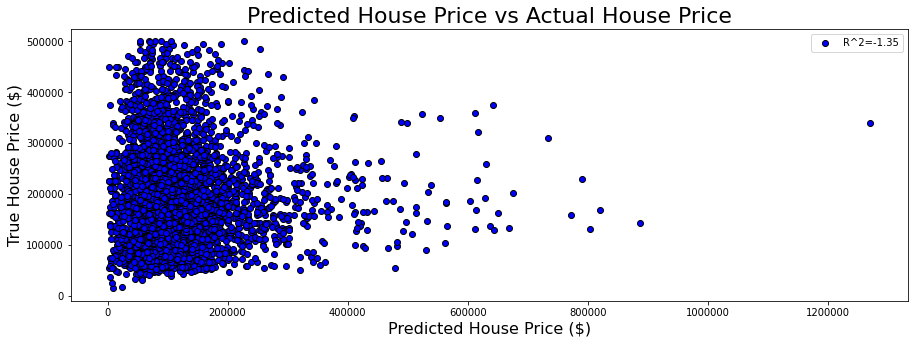

In [ ]:
plot_all_observations(y_test, y_pred, y_censor_label)
plot_uncensored_observations(y_test, y_pred, y_censor_label)

Well that looks like a disaster! What happened?


Let's define a function that will draw the coefficients' distributions for us when given a coefficient dataframe:

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

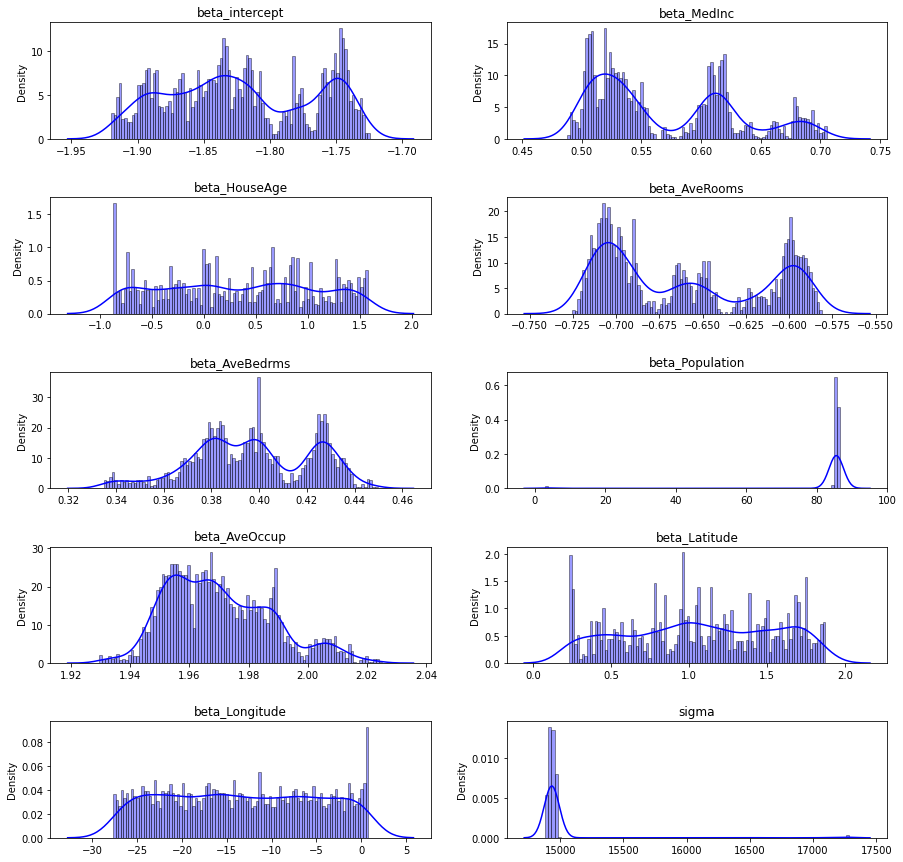

In [ ]:
def draw_coefficients(beta_df):
    figure, axis = plt.subplots(5,2, figsize=(15,15))


    for key, ax in zip(beta_df.columns, axis.ravel()):
        ax.set_title(key)
        sns.distplot(beta_df[key],
                     ax=ax,
                     bins=100,
                     color="blue",
                     kde=True,
                     axlabel=False,
                     hist_kws=dict(edgecolor="black"))

    plt.subplots_adjust(hspace=0.5)
    plt.show()

draw_coefficients(beta_df)

Those plots don't look like they converged.

Turns out for this problem, MCMC methods have a hard time with different scales for our data. They work much better when our features and target are scaled. Let's explore the performance of the same methodology with the data scaled

----

## Scaling Our Data

We are going to scale our X and y data using a standard scaler from `sklearn`. The standard scaler will scale each feature in X in such a way that it has a mean of 0.0, and a standard deviation of 1.0. To do so it will employ each variable's mean $\bar{x}$ and standard deviation $s$


This means, instead of trying to find a set of coefficients on the original data


$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n $$

we will find a set of coefficients on the scaled data:

$$y' = \beta'_0 + \beta'_1\frac{x_1 - \bar{x}_1}{s_1} + \beta'_2\frac{x_2 - \bar{x}_2}{s_2} + ... + \beta'_n\frac{x_n - \bar{x}_n}{s_n} $$

Where

$$y' = \frac{y}{y_{max}}$$

That is, y is scaled to be between 0–1 and the columns of X have been standardized.

In [ ]:
from sklearn.preprocessing import StandardScaler


# Scale X
my_x_scaler = StandardScaler()
X_train_scaled = my_x_scaler.fit_transform(X_train)

# Scale y
y_censor_label = y_train.max()
y_train_scaled = y_train/y_censor_label

In [ ]:
# Convert our data into pytorch tensors
X_train_torch = torch.tensor(X_train_scaled)
y_train_torch = torch.tensor(y_train_scaled)


# Clear previous parameters
pyro.clear_param_store()

# Perform inference again
my_kernel2 = NUTS(model_normal, max_tree_depth=7)

my_mcmc2 = MCMC(my_kernel2,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)


start_time = time.time()
my_mcmc2.run(X_train_torch,
             y_train_torch,
             california.feature_names)
end_time = time.time()

print()
print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 3100/3100 [04:33, 11.32it/s, step size=6.58e-02, acc. prob=0.891]


Inference ran for 4.56 minutes


Our algorithm ran much faster now, but if we recover the coefficients the algorithm found, those will be the coefficients on the scaled data. We would like to translate them back into the unscaled data so we can ask questions such as: "For each extra bedroom in the house, what will be the effect on the price?"


Luckily, we can manipulate our equation to retrieve the coefficients on the unscaled data. We begin with our original equation

$$y' = \beta'_0 + \beta'_1\frac{x_1 - \bar{x}_1}{s_1} + \beta'_2\frac{x_2 - \bar{x}_2}{s_2} + ... + \beta'_n\frac{x_n - \bar{x}_n}{s_n} $$

and we expand each fraction:

$$y' = \beta'_0 + \beta'_1\frac{x_1}{s_1} - \beta'_1\frac{\bar{x}_1}{s_1} + \beta'_2\frac{x_2}{s_2} - \beta'_2\frac{\bar{x}_2}{s_2} + ... + \beta'_n\frac{x_n}{s_n} - \beta'_n\frac{\bar{x}_n}{s_n} $$

We can then rearrange the equation as follows:

$$y' = \beta'_0 - \beta'_1\frac{\bar{x}_1}{s_1} - \beta'_2\frac{\bar{x}_2}{s_2} ... - \beta'_n\frac{\bar{x}_n}{s_n} + \frac{\beta'_1}{s_1}x_1 + \frac{\beta'_2}{s_2}x_2 + ... + \frac{\beta'_n}{s_n}x_n  $$

Recalling that

$$y' = \frac{y}{y_{max}}$$

we can finally rewrite our formula as follows:

$$y = y_{max}\big( \beta'_0 - \sum_{i=1}^n\beta'_i\frac{\bar{x}_i}{s_i} \big) + \frac{\beta'_1 y_{max}}{s_1}x_1 + \frac{\beta'_2 y_{max}}{s_2}x_2 + ... + \frac{\beta'_n y_{max}}{s_n}x_n  $$

We can create a function to perform the processing of the coefficients from the scaled data to the unscaled data

In [ ]:
def create_beta_df(beta_df, x_scaler, feature_names):

    i = 0
    # for each column except the intercept and the additional sigma term
    for col in beta_df:
        if (col != 'beta_intercept'):
            if ('beta_' in col):

                # subtract the appropriate value from the intercept (review intercept final expression)
                beta_df['beta_intercept'] -= (beta_df[col] * x_scaler.mean_[i])/x_scaler.scale_[i]

                # scale the coefficient (review each coefficient final expression)
                beta_df[col] /= x_scaler.scale_[i]
                i += 1

    return beta_df

Then we just employ that function on the retrieved coefficients after we retrieve them from the dictionary again:

In [ ]:
beta2_df = pd.DataFrame(my_mcmc2.get_samples())
beta2_df = create_beta_df(beta2_df, my_x_scaler, california.feature_names)

beta2_df *= y_censor_label   # multiply everything by y_max outside the function for reasons that will
                             # become clear later

Let's compare the prediction results

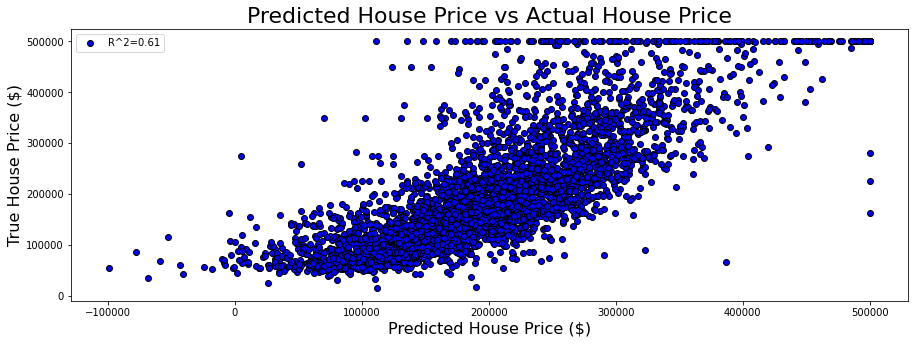

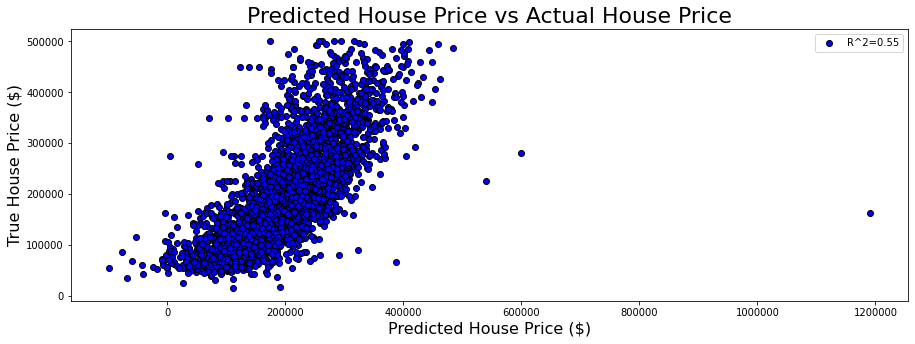

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

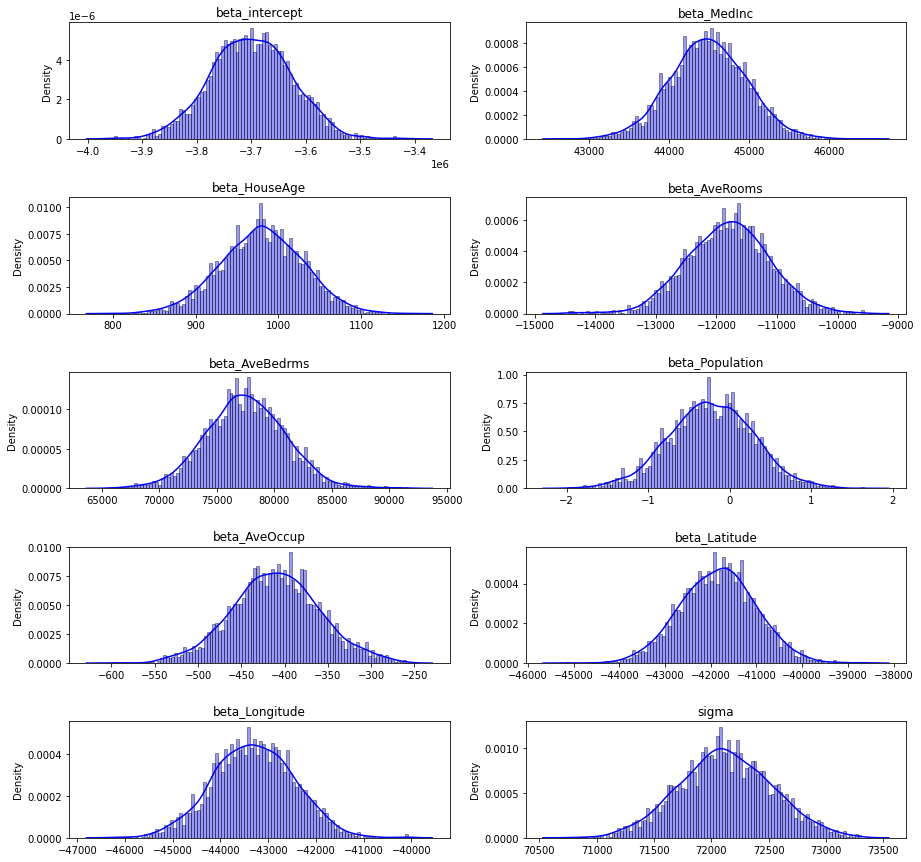

In [ ]:
linear_combination = predict_linear_combination(beta2_df, X_test)

y_pred = linear_combination

plot_all_observations(y_test, y_pred, y_censor_label)
plot_uncensored_observations(y_test, y_pred, y_censor_label)

draw_coefficients(beta2_df)

These values seem much closer to the values found by the linear regression from `sklearn`.

It seems like we got a comparable performance. The distributions look close to the values we got from scikit-learn. We also get a probability distribution for each coefficient so we can see our level of confidence in the value we found.


However, we can actually employ Pyro to do better! Recall that we saw our house prices are not normally distributed but in fact follow a gamma distribution. We can modify our code to reflect that in the model.

-----

## Improving our Predictions Using a Gamma Distribution

In order to better reflect the house distribution, we can employ a gamma distribution for our target values. Unlike the normal distribution which is defined by its mean and standard deviation, the gamma distribution is defined by two positive parameters which are the shape and the rate.


When constructing our model for a distribution other than normal, we need to employ a **link function** which will translate the linear combination of our parameters to the expected value, or the mean, of the distribution. We also would like to know the relationship between the mean and the distribution parameters. Luckily, for the gamma distribution this is defined as:

$$\mu = mean = \frac{shape}{rate}$$

However, if both the shape and rate parameters are positive, that means the mean must be positive as well. We need to make sure that our link function captures that. Therefore, I will use the following link function for the linear equation:

$$ln(y') = \beta'_0 + \beta'_1\frac{x_1 - \bar{x}_1}{s_1} + \beta'_2\frac{x_2 - \bar{x}_2}{s_2} + ... + \beta'_n\frac{x_n - \bar{x}_n}{s_n}$$

or

$$y' = e^{\beta'_0 + \beta'_1\frac{x_1 - \bar{x}_1}{s_1} + \beta'_2\frac{x_2 - \bar{x}_2}{s_2} + ... + \beta'_n\frac{x_n - \bar{x}_n}{s_n}}$$


Readers familiar with the `statsmodels` package will know it has a GLM module (for more details on statsmodels GLMs, I recommend [this article](https://towardsdatascience.com/generalized-linear-models-9cbf848bb8ab)) which can model the relationship proposed here by employing the `statsmodels.genmod.families.family.Gamma` family and the `statsmodels.genmod.families.links.log` link functions. However, for the purposes of this article I wanted to show the process involved in reproducing this functionality in a Bayesian framework.

Interestingly enough, to recover the coefficients for the unscaled data, the math works out fairly similarly except for the constant. Keeping in mind that:

$$y' = \frac{y}{y_{max}} = \frac{\mu}{y_{max}}$$

and that

$$ln(\frac{y}{max(y)}) = ln(y) - ln(y_{max})$$

We can find that our equation can be written as:

$$ln(y) = \big(ln(y_{max}) + \beta'_0 - \sum_{i=1}^n\beta'_i\frac{\bar{x}_i}{s_i} \big) + \frac{\beta'_1}{s_1}x_1 + \frac{\beta'_2}{s_2}x_2 + ... + \frac{\beta'_n}{s_n}x_n  $$

or

$$\mu = y = e^{\big(ln(y_{max}) + \beta'_0 - \sum_{i=1}^n\beta'_i\frac{\bar{x}_i}{s_i} \big) + \frac{\beta'_1}{s_1}x_1 + \frac{\beta'_2}{s_2}x_2 + ... + \frac{\beta'_n}{s_n}x_n}$$

Let's define our model, but now using a gamma distribution:

In [ ]:
def model_gamma(X, y, column_names):
    pyro.enable_validation(True)

    min_value = torch.finfo(X.dtype).eps
    max_value = torch.finfo(X.dtype).max

    # We still need to calculate our linear combination

    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)


    # Also define coefficient priors
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)

        linear_combination = linear_combination + (X[:, i] * beta_coef)


    # But now our mean will be e^{linear combination}
    mean = torch.exp(linear_combination).clamp(min=min_value, max=max_value)

    # We will also define a rate parameter
    rate = pyro.sample("rate", dist.HalfNormal(scale=10.0)).clamp(min=min_value)

    # Since mean = shape/rate, then the shape = mean * rate
    shape = (mean * rate)



    # Now that we have the shape and rate parameters for the
    # Gamma distribution, we can draw samples from it and condition
    # them on our observations
    with pyro.plate("data", y.shape[0]):

        outcome_dist = dist.Gamma(shape, rate)

        observation = pyro.sample("obs", outcome_dist, obs=y)

You'll notice our code is slightly different but we are still calculating a linear combination of our $X$ data and our coefficients, except now we take the `exp` of that combination to get the mean value of our data point. We also sample a rate parameter, and use the mean and rate to calculate the appropriate shape parameter.

Given our shape and rate parameters, we can define a gamma distribution and ask Pyro to optimize our coefficients and rate parameters in order to build a model most likely based on our data.

Let's optimize this new model and look at the results:

In [ ]:
# Clear all previous runs of pyro
pyro.clear_param_store()

# And again, perform inference
my_kernel3 = NUTS(model_gamma, max_tree_depth=7)


my_mcmc3 = MCMC(my_kernel3,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)



start_time = time.time()
my_mcmc3.run(X_train_torch,
             y_train_torch,
             california.feature_names)
end_time = time.time()

print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 3100/3100 [34:29,  1.50it/s, step size=1.35e-02, acc. prob=0.961]

Inference ran for 34.49 minutes


We can grab the coefficients from this sampler as well. However, this time we have to treat the value of `y_max` slightly differently.

In [ ]:
beta3_df = pd.DataFrame(my_mcmc3.get_samples())
beta3_df = create_beta_df(beta3_df, my_x_scaler, california.feature_names)

# Notice now we have to use the y_max value slightly differently
beta3_df['beta_intercept'] += np.log(y_censor_label)

Let's compare this model's performance by calculating the predictions and comparing them to the observed values

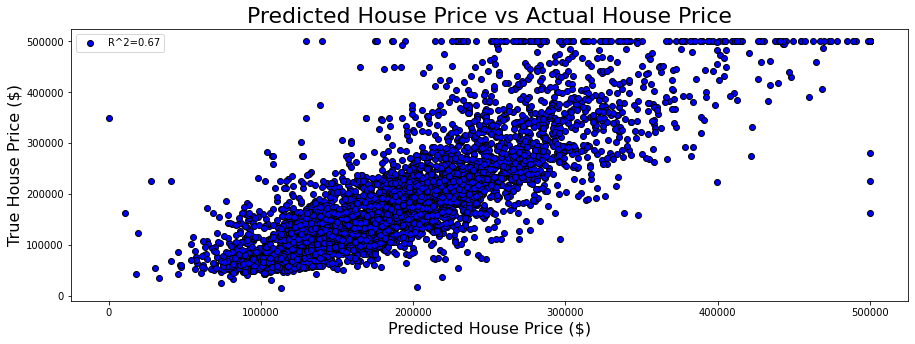

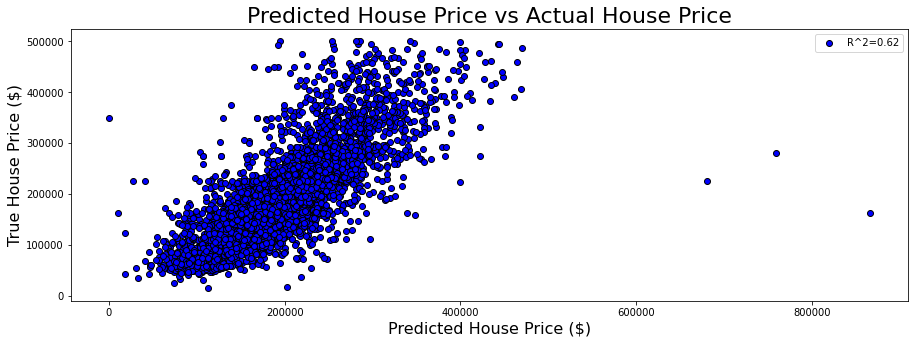

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

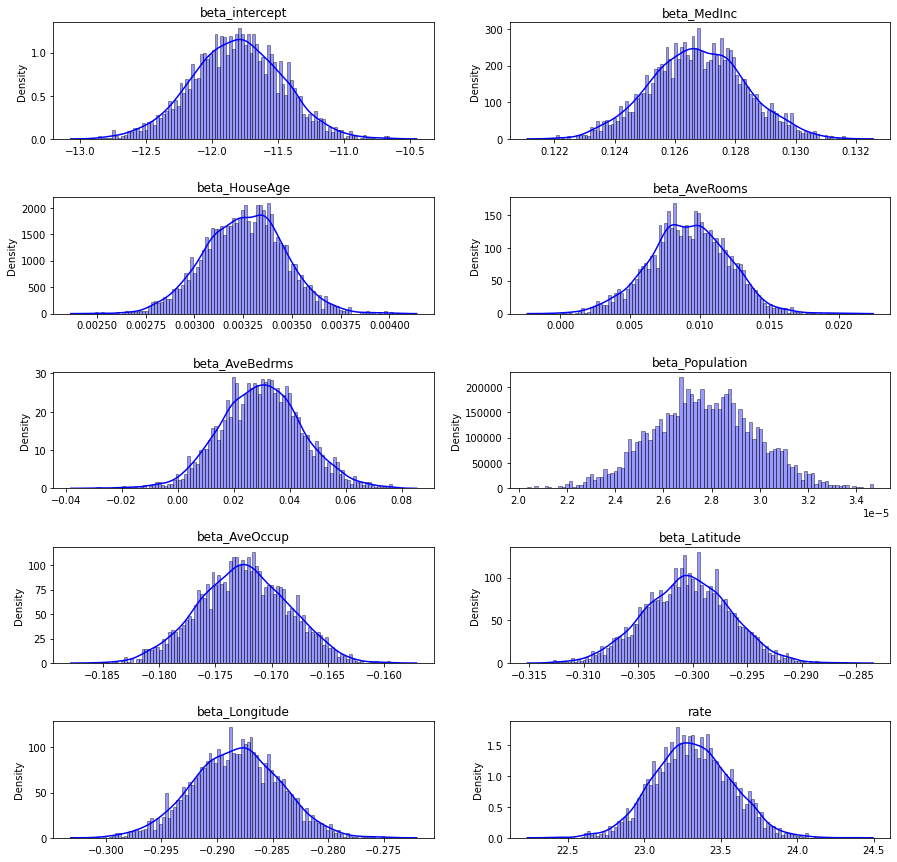

In [ ]:
linear_combination = predict_linear_combination(beta3_df, X_test)

# We have to take the EXP of the linear combination now to get the expected values
y_pred = np.exp(linear_combination)

plot_all_observations(y_test, y_pred, y_censor_label)
plot_uncensored_observations(y_test, y_pred, y_censor_label)

draw_coefficients(beta3_df)

How do we interpret these coefficients?

Well, they now modify our price by a factor. Recall that our equation is now:

$$y = e^{\beta_0 + \beta_1x_1 + ... + \beta_nx_n}$$

which is equivalent to

$$y = e^{\beta_0}\times e^{\beta_1x_1}\times \dots \times e^{\beta_nx_n}$$

So each increase of `x_1` by one unit, will increases the house price by a factor of `e^{x_1}`.

For example, the mean value for beta_AvgRooms is ~0.007, so each additional room will increase the house price, on average, by a factor of $e^{0.007}$ = 1.007 (so if a house cost \\$250,000, adding an additional room would make its value \\$251,756).


Other parameters seem to qualitatively agree between the two models, but the model employing the gamma distribution is giving us better predictions on the unseen data.
There is still the problem of run-time, however. In general, if we want to do inference in reasonable time, we have to turn to the method of variational inference.

## Faster Run-time with SVI

Pyro implements Stochastic Variational Inference (SVI) for faster inference. Under the SVI approach, instead of trying to sample from the posterior distribution directly, we simply optimize the parameters of some pre-defined distribution to match our observed data.

For example, we can choose to represent all our coefficients, and rate, as normal distributions. This way SVI simply needs to find an appropriate mean and standard deviation for each normal distribution such that it agrees with our data as much as possible.

In [ ]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
from pyro.optim import ClippedAdam
from pyro.infer.autoguide import AutoDiagonalNormal

# Convert the data into tensors
X_train_torch = torch.tensor(X_train_scaled)
y_train_torch = torch.tensor(y_train_scaled)

pyro.clear_param_store()

# Provide a guide which fits a pre-defined distribution over each
# hidden parameter. The AutoDiagonalNormal guide fits a normal
# distribution over each coefficient and our rate parameter
my_guide = AutoDiagonalNormal(model_gamma)


# Initialize the SVI optimzation class
my_svi = SVI(model=model_gamma,
             guide= my_guide,
             optim=ClippedAdam({"lr": 0.01, 'clip_norm': 1.0}), # optimizer
             loss=Trace_ELBO())

losses = []

start_time = time.time()

# Perform optimization
for i in range(5000):

    loss = my_svi.step(X_train_torch,
                       y_train_torch,
                       california.feature_names)

    normalized_loss = loss/X_train_torch.shape[0]

    # Tabulate the loss for plotting
    losses.append(normalized_loss)
    if (i % 250 == 0):
        print(f'iter: {i}, normalized loss:{round(normalized_loss,2)}')


# To obtain samples for our coefficient distributions
# we need to use our optimized distributions to
# predict some new values
predictive = Predictive(model=model_gamma,
                        guide= my_guide,
                        num_samples=SAMPLE_NUMBER)
with torch.no_grad():
    samples = predictive(X_train_torch,
                         y_train_torch,
                         california.feature_names)


end_time = time.time()

print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

iter: 0, normalized loss:27236029.21
iter: 250, normalized loss:-0.42
iter: 500, normalized loss:-0.67
iter: 750, normalized loss:-0.67
iter: 1000, normalized loss:-0.67
iter: 1250, normalized loss:-0.68
iter: 1500, normalized loss:-0.67
iter: 1750, normalized loss:-0.67
iter: 2000, normalized loss:-0.68
iter: 2250, normalized loss:-0.68
iter: 2500, normalized loss:-0.68
iter: 2750, normalized loss:-0.68
iter: 3000, normalized loss:-0.67
iter: 3250, normalized loss:-0.68
iter: 3500, normalized loss:-0.68
iter: 3750, normalized loss:-0.68
iter: 4000, normalized loss:-0.67
iter: 4250, normalized loss:-0.68
iter: 4500, normalized loss:-0.68
iter: 4750, normalized loss:-0.68
Inference ran for 1.29 minutes


Grabbing the result from the SVI samples is a bit more involved than the MCMC samples since the samples return as a dictionary of tensors with gradients, and it also returns an additional key called `obs` which is not relevant for our analysis of the coefficients (it is a set of estimations for the training data).

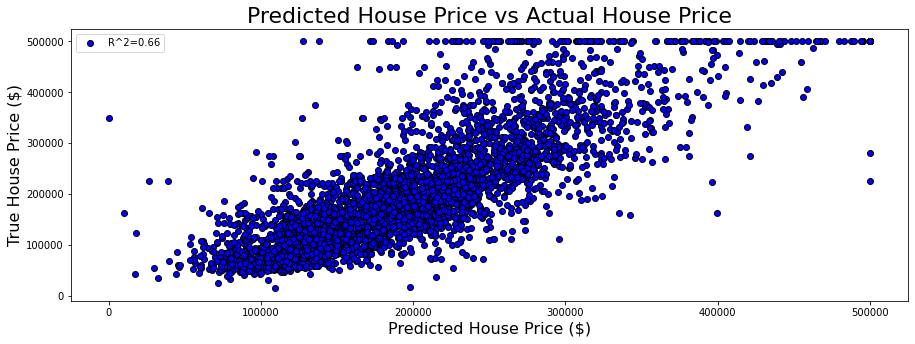

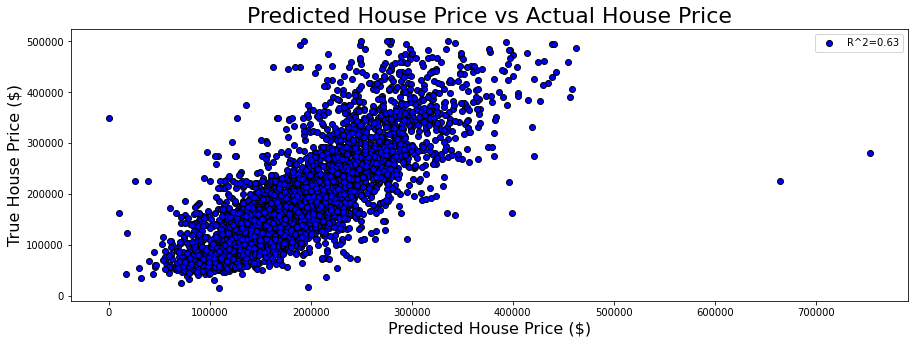

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

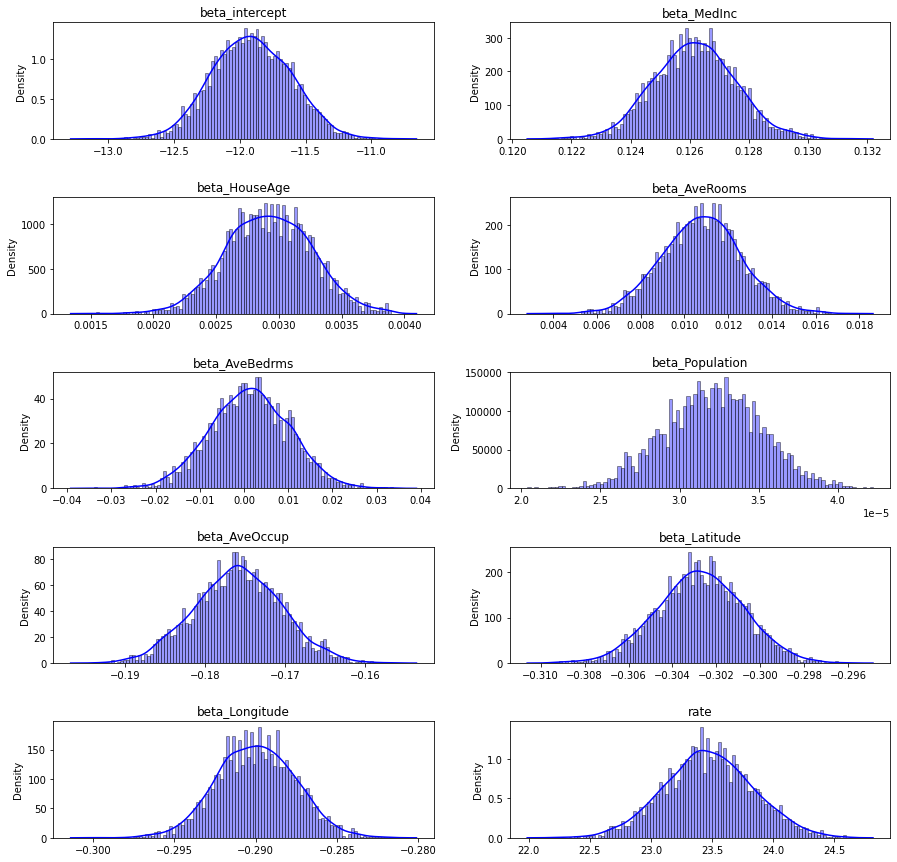

In [ ]:
samples.pop('obs');

# Turn the resulting dictionary into a dataframe. Each element is a 1x1 pytorch tensor
# so we grab its value using .item()
beta_svi_df = pd.DataFrame(samples, index=range(SAMPLE_NUMBER)).applymap(lambda x: x[0].item())

# From here on it's the same as what we did with the MCMC sample
beta_svi_df = create_beta_df(beta_svi_df, my_x_scaler, california.feature_names)
beta_svi_df['beta_intercept'] += np.log(y_censor_label)

linear_combination = predict_linear_combination(beta_svi_df, X_test)

y_pred = np.exp(linear_combination)

plot_all_observations(y_test, y_pred, y_censor_label)
plot_uncensored_observations(y_test, y_pred, y_censor_label)

draw_coefficients(beta_svi_df)

And there we go. We now have the power to build custom GLMs using Pyro using either MCMC sampling methods or SVI optimization methods.

One important feature of Pyro is that it forces the writer to be very explicit about their assumptions and their understanding of the data generating process. This can be extremely useful in promoting an in-depth exploration of the data before any modeling is done, contributing to a deeper understanding of all important factors.